GoEat - Food Recommender
==
‘음식’은 의식주와 더불어 인간 생활의 세 가지 기본 요소 중의 하나이다. 매 끼니마다 무엇을 먹을지 결정하는 것은 인생을 살아가는 속에서 떼어놓을 수 없는 고민거리이다. 닐슨코리아가 2018년 4-5월에 전국 19세 이상 70세 미만 성인남녀 1천명을 대상으로한 ‘한국인의 식생활에 관한 조사’에 따르면 한국인들이 집에서 식사를 하는 것은 하루에 한번에 불과하다고 한다. 즉, 하루에 세끼를 먹는다고 가정하면 두끼는 밖에서 먹는 다는 것이고, 무엇을 먹을지 고민하는 것을 우리는 하루에 두번 씩 한다는 것이다. 음식을 고를 때 고려하는 요인들은 여러가지가 있다. 가령, 먹은 지 얼마 안 된 메뉴는 다음 끼니에서는 먹지 않고 싶을 수 있다. 혹은 기분에 따라 그날따라 유달리 당기는 음식이 생길 수 있다. 하지만 그럼에도 불구하고 어떤 음식을 먹을지 딱 하나를 정하는 것은 여간 어려운 일이 아니다.
여러 명이서 식사를 할 때는 이 모든 요소들을 고려하여 모두가 만족할만한 메뉴를 선정해야 한다는 점에서 더 어렵다. 친구들과 음식을 고를 때 선뜻 메뉴를 제안하지 못하고 서로의 눈치를 살펴가며 메뉴를 정하는 답답함에서 해당 프로젝트를 착안하게 되었다.
본 프로젝트에서는 개인의 식사 패턴, 그날의 감정 상태 등의 복합적인 요소들을 고려한 메뉴 추천 서비스를 제작하고자 한다. 우선적으로 사용자가 입력한 감정 데이터와 음식 메뉴 사이의 상관관계를 파악할 것이다. 여러 사람들의 기호, 감정, 식사 패턴 등의 데이터를 복합적으로 고려하여, 추천 알고리즘을 통해 모두에게 부합하는 메뉴를 선별해내는 것이 궁극적인 목표이다.


0.Import Modules & Data
--

In [1]:
#import modules
import numpy as np
import pandas as pd
import GoEat
from GoEatWebCrawler import GoEatWebCrawler
from collections import Counter
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.utils import concordance, pprint
import scipy
import sklearn
import konlpy
import re
import pickle
import pymysql

데이터 베이스에서 데이터 로드

In [5]:
#set seed to get constant data
np.random.seed(10)

In [2]:
# Data Base 불러오기

db = pymysql.connect(host = 'DESKTOP-PD3BJSG',port=3306,user='mysql',password ='mysql93',db='goeat',charset = 'utf8')

cursor = db.cursor()

sql ="SELECT table_name FROM information_schema.tables where table_schema='goeat'"
cursor.execute(sql)
table = cursor.fetchall()

table_names = []
for name in table:
    table_names.append(name[0])
    
for table_name in table_names:
    table_select = "SELECT * FROM " + table_name
    col_show = col = "SHOW COLUMNS FROM " + table_name
    
    cursor.execute(table_select)
    data = cursor.fetchall()

    cursor.execute(col_show)
    columns = cursor.fetchall()
    
    col_name = []
    for column in columns:
        col_name.append(column[0].replace('\ufeff',''))
    
    vars()[table_name +'_df'] = pd.DataFrame(list(data),columns = col_name)
    vars()[table_name +'_df'].index = vars()[table_name +'_df'].index + 1
    
tfidf_df = tfidf_df.drop('foodIndex',axis=1)

user_profiles = {}
for key, value in list(zip(user_profiles_df.loc[:,'userIndex'].values, user_profiles_df.loc[:,user_profiles_df.columns != 'userIndex'].values)):
    user_profiles[key] = value.reshape(1, -1)

In [268]:
#load data
df_user_info = pd.read_csv('data\\info\\df_user_info.csv')
df_user_detail =pd.read_csv('data\\info\\df_user_detail.csv')
food_df = pd.read_csv('data\\info\\food_df.csv')
food_detail_df = pd.read_csv('data\\info\\food_detail_df.csv')
interactions_df = pd.read_csv('data\\info\\interactions_df.csv')

#load tfidf
with open('tfidf.pickle', 'rb') as f:
    tfidf_matrix, tfidf_feature_names = pickle.load(f)

In [4]:
#save data
df_user_info.to_csv('data\\info\\df_user_info.csv',index=False)
df_user_detail.to_csv('data\\info\\df_user_detail.csv',index=False)
food_df.to_csv('data\\info\\food_df.csv',index=False)
food_detail_df.to_csv('data\\info\\food_detail_df.csv',index=False)
interactions_df.to_csv('data\\info\\interactions_df.csv',index=False)

#save tfidf
with open('tfidf.pickle', 'wb') as f:
    pickle.dump([tfidf_matrix, tfidf_feature_names], f)


1.Preprocessing
--

In [4]:
# smoothen user preference
interactions_full_df = interactions_df \
                    .groupby(['userIndex', 'foodIndex'])['eventStrength'].mean() \
                    .apply(GoEat.smooth_user_preference).reset_index()

In [146]:
#split test and test set
interactions_train_df, interactions_test_df = \
GoEat.interactions_train_test_split(interactions_full_df, test_size=0.20)

# interactions on Train set: 8280
# interactions on Test set: 2070


2.Preprocessing for Collaborative filtering
--

Singlar Vector Decomposition을 사용하여 user-item matrix를 압축할 것이다.

In [154]:
cf_preds_df = GoEat.users_items_svd(interactions_train_df, nfactors = 2)

3.Preprocessing for Content-based filtering
--

In [71]:
df_food_attribtue = pd.read_csv('data\\info\\food_attribute.csv')
df_food_attribute = df_food_attribtue.drop('foodname',axis=1).reset_index()
df_food_attribute.columns = ['foodIndex','foodAttribute']
df_food_attribute.loc[:,'foodIndex'] = df_food_attribute.loc[:,'foodIndex'] + 1
df_food_attribute = pd.merge(food_df,df_food_attribute,how='outer')

In [72]:
with open('data\\stopwords-ko.txt', 'r',encoding='utf-8') as f:
    lines = f.readlines()
    stopwords_ko = list(map(lambda x: x.rstrip('\n'),lines))

In [106]:
#tfidf vectorize

#attribute
tfidf_matrix_attribute, tfidf_feature_names_attribute \
= GoEat.tfidf_vectorizer(df_food_attribute,'foodAttribute',stopwords_ko)

#recipe
tfidf_matrix_recipe, tfidf_feature_names_recipe = \
GoEat.tfidf_vectorizer(food_detail_df,'foodRecipeNoun',stopwords_ko )


In [149]:
#build user profiles

#attribute
builder_attribute= GoEat.user_profiles_builder()
builder_attribute.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles_attribute = builder_attribute.build_users_profiles(interactions_df,food_df,tfidf_matrix_attribute)

#recipe
builder_recipe= GoEat.user_profiles_builder()
builder_recipe.get_interacted_indexed_df(interactions_train_df,food_df)
user_profiles_recipe = builder_recipe.build_users_profiles(interactions_train_df,food_df,tfidf_matrix_recipe)

In [105]:
tfidf_feature_names = tfidf_df.columns
tfidf_matrix = scipy.sparse.csr_matrix(tfidf_df)
tfidf = pd.DataFrame(tfidf_matrix_recipe.todense(),columns = tfidf_feature_names_recipe)

In [104]:
tfidf.to_csv('tfidf.csv',encoding='cp949',index=False)

In [98]:
user_profiles_list = [ ]
for k,v in user_profiles_recipe.items():
    
    user_profiles_list.append(user_profiles_recipe[k][0])

In [99]:
user_profiles_df = pd.DataFrame(user_profiles_list ,columns = tfidf_feature_names_recipe)

In [100]:
user_profiles_df.to_csv('user_profiles.csv',encoding='cp949',index=False)

token test

In [21]:
myprofile = user_profiles[2]
print(myprofile.shape)
df_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        myprofile.flatten().tolist()), key=lambda x: -x[1]),
             columns=['token', 'relevance'])
df_profile.head(10)

(1, 23)


,token,relevance
0,걸쭉함,0.342475
1,닭고기,0.342475
2,된장,0.342475
3,멸치,0.342475
4,인도식,0.264975
5,참기름,0.264975
6,발효,0.242166
7,짭짤함,0.242166
8,감자,0.209987
9,유부,0.209987


4.Model Generation
--

In [157]:
cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
cb_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix_recipe)
hybrid_model = GoEat.HybridRecommender(cb_model, cf_model, food_df,method = 'harmonic')
model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 

In [2]:
import datetime

In [ ]:
user_index = int(input('userIndex를 입력해주세요 : '))
new_user = GoEat.cold_start_question(user_index,food_df,10)

interactions_df = interactions_df.append(new_user,ignore_index=True)

interactions_full_df = interactions_df \
                    .groupby(['userIndex', 'foodIndex'])['eventStrength'].mean() \
                    .apply(GoEat.smooth_user_preference).reset_index()
##Content-based filtering##

#build user profile
builder.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles[user_index] = builder.build_users_profile(user_index)

#builder.get_interacted_indexed_df(interactions_full_df,food_df)

#content-based model building
cb_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix)

In [627]:
interactions_df[
    interactions_df.foodIndex.isin(
        df_food.foodIndex[
            df_food.foodName == '햄버거'].values)].groupby(interactions_df.eventStrength).count().\
drop(['userIndex','eventStrength'],axis =1).foodIndex

eventStrength
1     8
2    16
3    54
4    71
5    68
Name: foodIndex, dtype: int64

In [155]:
cf_model.recommend_items(7,topn=10,verbose=True)

,recStrength,foodIndex,foodName
0,2.332498,7,삼겹살
1,2.324431,25,스테이크
2,2.321842,44,치킨
3,2.313733,18,초밥
4,2.286541,27,파스타
5,2.281521,37,떡볶이
6,2.280578,8,수육
7,2.258158,32,샤브샤브
8,2.250775,3,된장찌개
9,2.250736,9,제육볶음


In [160]:
cb_model.recommend_items(14,topn=10,verbose=True)

,recStrength,foodIndex,foodName
0,0.194105,16,게장
1,0.194105,7,삼겹살
2,0.194105,44,치킨
3,0.194105,25,스테이크
4,0.194105,18,초밥
5,0.194105,35,커리
6,0.194105,28,함박스테이크
7,0.194105,5,닭도리탕
8,0.194105,32,샤브샤브
9,0.194105,8,수육


In [153]:
hybrid_model.recommend_items(12,topn=10,verbose=True)

,recStrengthHybrid,foodIndex,foodName
0,0.338464,7,삼겹살
1,0.338375,25,스테이크
2,0.338346,44,치킨
3,0.338256,18,초밥
4,0.337947,27,파스타
5,0.337880,8,수육
6,0.337684,37,떡볶이
7,0.337465,29,피자
8,0.337309,9,제육볶음
9,0.337062,30,짜장면


5.Recipe vs Tagging (Content-based Filtering)
--

만개의 레시피(http://www.10000recipe.com/) 사이트에서 레시피를 크롤링하여 구성한 feature와 사람이 직접 음식에 대하여 태깅을 하여 만들어낸 feature 중 어느 모델의 성능이 더 좋은지 비교하여 보겠다.

웹사이트에서 레시피를 크롤링하여 만들어낸 feature는 그 개수가 많아서 더욱 세부적인 성향파악이 가능하지만 사람이 이해 할 수 없는 token들이 많이 생기는 단점이 있고, 사람이 직접 음식에 대하여 태깅한 것은 그 수는 적지만 사람이 이해하기 쉬운 token들로 구성된다.



In [31]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

In [94]:

df_attribute =  pd.DataFrame(attribute_matrix.toarray(),columns = vocab_attribute)

In [53]:
#tfidf vectorize

#tag frequency
cv_attribute = CountVectorizer()
attribute_matrix = cv_attribute.fit_transform(df_food_attribute.foodAttribute)
attribute_feature_names = cv_attribute.get_feature_names()

#tag tf-idf
tfidf_matrix_tag, tfidf_feature_names_tag \
= GoEat.tfidf_vectorizer(df_food_attribute,'foodAttribute',stopwords_ko)

#recipe
tfidf_matrix_recipe, tfidf_feature_names_recipe = \
GoEat.tfidf_vectorizer(food_detail_df,'foodRecipeNoun',stopwords_ko )

In [76]:
#build user profiles

#attribute frequency
builder_tag_freq= GoEat.user_profiles_builder()
builder_tag_freq.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles_tag_freq = builder_attribute.build_users_profiles(interactions_df,food_df,attribute_matrix)


#attribute tf-idf
builder_tag_tfidf = GoEat.user_profiles_builder()
builder_tag_tfidf.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles_tag = builder_attribute.build_users_profiles(interactions_df,food_df,tfidf_matrix_tag)

#recipe
builder_recipe= GoEat.user_profiles_builder()
builder_recipe.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles_recipe = builder_recipe.build_users_profiles(interactions_df,food_df,tfidf_matrix_recipe)

In [79]:
#model generation

#attribute frequency
cb_model_tag_freq = GoEat.CBRecommender(food_df,user_profiles_tag_freq,attribute_matrix)

#attribute tf-idf
cb_model_tag_tfidf = GoEat.CBRecommender(food_df,user_profiles_tag,tfidf_matrix_tag)

#recipe
cb_model_recipe = GoEat.CBRecommender(food_df,user_profiles_recipe,tfidf_matrix_recipe)

In [171]:
import time
from sklearn.model_selection import KFold


model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 

models = [cb_model_tag_freq, cb_model_tag_tfidf,  cb_model_recipe]
model_names = ['Content-based(Tag-freq)','Content-based(Tag-tfidf)','Content-based(Recipe)']
metrics = ['recall@5','recall@10','ndcg@5','ndcg@10']

accuracies = np.zeros((len(models),len(metrics),5))
total_length = len(models)*5

count = 0
start_time = time.time()
cv = KFold(5, shuffle=True, random_state=0)
for idx_fold, (idx_train, idx_test) in enumerate(cv.split(interactions_full_df)):
    interactions_train_df = interactions_full_df.iloc[idx_train]
    interactions_test_df = interactions_full_df.iloc[idx_test]
    

  
    
    
    model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 
    
    for idx_model, model in enumerate(models):
        
        with HiddenPrints():
            global_metrics, detailed_results_df = model_evaluator.evaluate_model(model)
        
        count = count + 1
        
        if count % 5 == 0:
            endtime = time.time() - start_time
            
            percent = round(count/total_length*100,2)
            print('%d percent done(%f seconds)'%(percent,endtime))
            
            approx_time = (endtime/count*total_length - endtime)/60
            
            print('approx. %f minute left'%(round(approx_time)))
        
        for idx_metric, metric in enumerate(metrics):
            accuracies[idx_model][idx_metric][idx_fold] = global_metrics[metric]
        
model_means=[]

for idx_model in range(len(models)):
    metric_means = []
    
    for idx_metric in range(len(metrics)):
        metric_mean = np.mean(accuracies[idx_model][idx_metric])
        metric_means.append(metric_mean)
    
    model_means.append(metric_means)            


kfold_tag_vs_recipe_result = pd.DataFrame(model_means,
             index=model_names,columns=metrics)   

print('complete after %f minutes'%((time.time() - start_time)/60))

kfold_tag_vs_recipe_result
        

33 percent done(77.477004 seconds)
approx. 3.000000 minute left
66 percent done(151.340891 seconds)
approx. 1.000000 minute left
100 percent done(215.030580 seconds)
approx. 0.000000 minute left
complete after 3.583976 minutes


,recall@5,recall@10,ndcg@5,ndcg@10
Content-based(Tag-freq),0.224444,0.386860,0.167353,0.186762
Content-based(Tag-tfidf),0.548502,0.657778,0.738916,0.621979
Content-based(Recipe),0.981063,0.984058,0.995294,0.988855


In [172]:
kfold_tag_vs_recipe_result.to_csv('evaluation\\kfold_tag_vs_recipe_result')

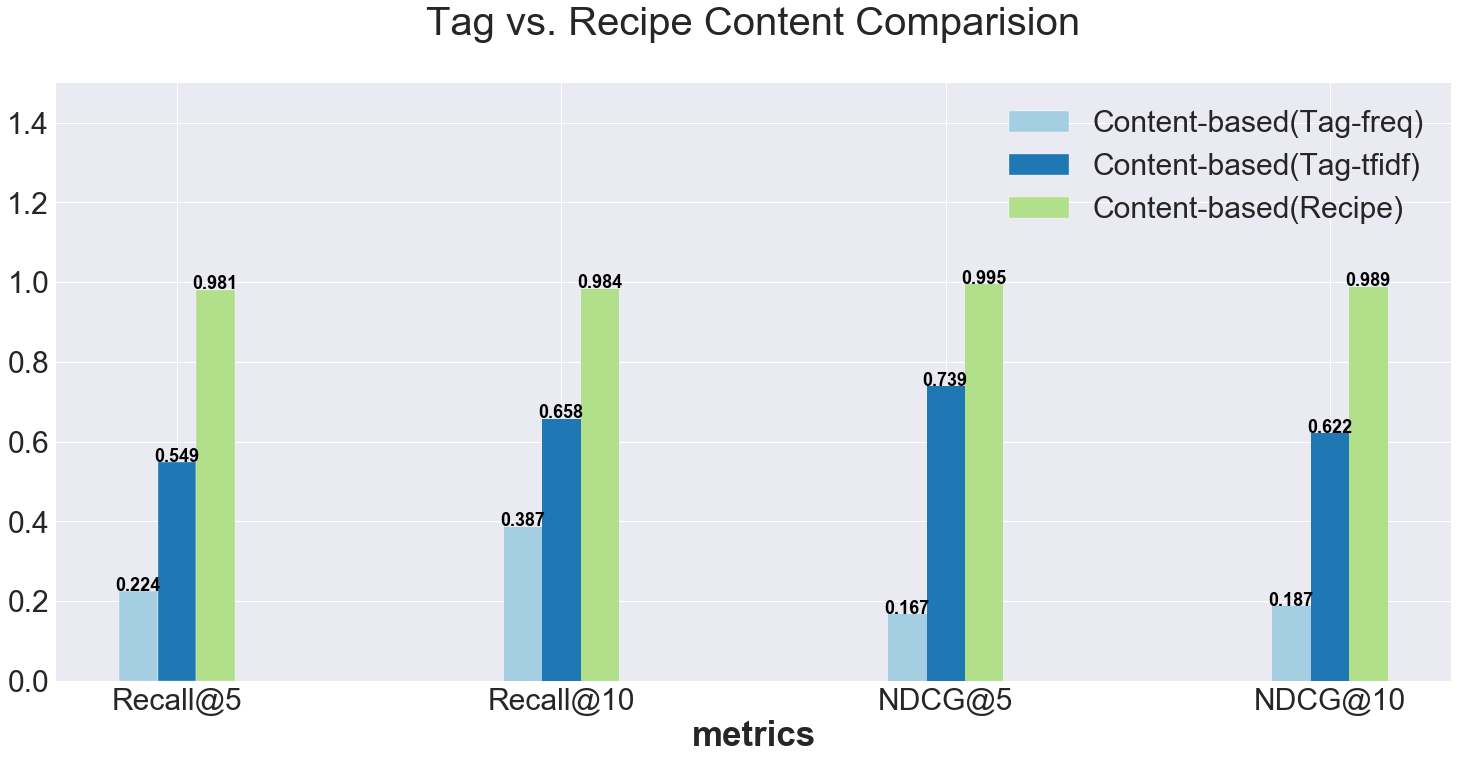

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

model_names = ['Content-based(Tag-freq)','Content-based(Tag-tfidf)','Content-based(Recipe)']

# set width of bar
ax2 = plt.figure(figsize=(25,11))
barWidth = 0.1

palettes = sns.color_palette("Paired", len(model_names))
# set height of bar
for idx ,model_name in enumerate(model_names):
    bars = kfold_attribute_vs_recipe_result.loc[model_name].tolist()
    if idx == 0:
        r = np.arange(len(bars))
    else:
        r = [x + barWidth for x in r_previous]
    
    r_previous = r
    
    plt.bar(r, bars, color=palettes[idx], width=barWidth, edgecolor='white', label=model_name)
    
    for r_value,value in zip(r,bars):
            plt.text(r_value-0.06, value+0.001, str(round(value,3)),
                     color='black', fontweight='bold',fontsize = 18)
    
plt.xlabel('metrics', fontweight='bold',fontsize =35)
plt.xticks([r + barWidth for r in range(len(bars))], ['Recall@5','Recall@10','NDCG@5','NDCG@10'],fontsize= 30)
plt.yticks(fontsize = 30)
plt.ylim(0,1.5)
plt.title('Tag vs. Recipe Content Comparision\n',fontsize = 40)
# Create legend & Show graphic
plt.legend(loc = 'upper right',fontsize= 30)
plt.show()
ax2.savefig('evaluation\\content_based_ModelsComparision.png')


비교 결과 사람이 직접 태그한 feature에 비해 웹사이트에서 레시피를 크롤링하여 구성한 feature가 월등히 더 좋은 것을 알 수 있다.

6.Grid Search to decide number of factors in SVD (Collaborative Filtering)
--

잠재요인 모델은 잠재요인을 통하여 user-item matrix를 낮은 차원으로 압축한다. 여기에서는 Singlar Vector Decomposition을 사용하여 user-item matrix를 압축할 것이다. 이 때 중요한 결정 중 하나는 잠재요인의 개수를 몇개로 하는가이다. 요인의 수가 많을 수록 압축한 것을 복원 하였을 때 원래의 matrix와 비슷해지지만, 일반화가 되지 않아서 학습하지 않은 결과에 대해서는 부정확한 예측을 할 수 있다. 요인의 수가 적을 수록 모델을 더욱 일반화할 수 있다.


그렇기 때문에 요인의 개수를 몇개로 설정하느냐는 매우 중요한 결정사항이다. 여기서는 Grid Search를 통해 몇개의 요인을 설정헀을 때 모델이 추천을 가장 잘 하는지를 알아보도록 하겠다.



In [12]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [114]:
cf_preds_df = GoEat.users_items_svd(interactions_full_df, nfactors = 5)

In [115]:
from sklearn.model_selection import KFold
import time

cf_model = GoEat.CFRecommender(cf_preds_df, food_df)

nfactors = list(range(5,76,5))
metrics = ['recall@5','recall@10','ndcg@5','ndcg@10']

total_length =len(nfactors) * 5

accuracies = np.zeros((len(nfactors),len(metrics),5))

start_time = time.time()

count = 0

cv = KFold(5, shuffle=True, random_state=0)
for idx_fold, (idx_train, idx_test) in enumerate(cv.split(interactions_full_df)):
    interactions_train_df = interactions_full_df.iloc[idx_train]
    interactions_test_df = interactions_full_df.iloc[idx_test]
    model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 
    
    for idx_nfactor, nfactor in enumerate(nfactors):
        #cf_preds_df = GoEat.users_items_svd(interactions_train_df, nfactors = nfactor)
        cf_preds_df = GoEat.users_items_svd(interactions_full_df, nfactors = nfactor)
        cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
        with HiddenPrints():
            global_metrics, detailed_results_df = model_evaluator.evaluate_model(cf_model)
        
        count = count + 1
        if count % 10 == 0:
            endtime = time.time() - start_time
            
            percent = round(count/total_length*100,2)
            print('%d percent done(%f seconds)'%(percent,endtime))
            
            approx_time = (endtime/count*total_length - endtime)/60
            
            print('approx. %f minute left'%(round(approx_time)))
        
        for idx_metric, metric in enumerate(metrics):
            accuracies[idx_nfactor][idx_metric][idx_fold] = global_metrics[metric]
        
nfactor_means=[]

for idx_nfactor in range(len(nfactors)):
    metric_means = []
    
    for idx_metric in range(len(metrics)):
        metric_mean = np.mean(accuracies[idx_nfactor][idx_metric])
        metric_means.append(metric_mean)
    
    nfactor_means.append(metric_means)
        


NfactorGridSearch_result = pd.DataFrame(nfactor_means,
             index=nfactors,columns=metrics)   

print('complete after %f seconds'%(time.time() - start_time))

NfactorGridSearch_result


13 percent done(109.664748 seconds)
approx. 12.000000 minute left
26 percent done(215.409980 seconds)
approx. 10.000000 minute left
40 percent done(318.412546 seconds)
approx. 8.000000 minute left
53 percent done(414.840690 seconds)
approx. 6.000000 minute left
66 percent done(530.607326 seconds)
approx. 4.000000 minute left
80 percent done(643.160354 seconds)
approx. 3.000000 minute left
93 percent done(742.908621 seconds)
approx. 1.000000 minute left
complete after 800.637252 seconds


,recall@5,recall@10,ndcg@5,ndcg@10
5,0.993333,0.997295,0.881449,0.918775
10,0.969855,0.985217,0.875100,0.906607
15,0.923575,0.959903,0.870730,0.883019
20,0.862415,0.923768,0.857805,0.844080
25,0.795942,0.891304,0.830768,0.793641
30,0.718164,0.848696,0.783889,0.731675
35,0.644734,0.813237,0.700039,0.656062
40,0.574300,0.779034,0.594218,0.571436
45,0.493913,0.754106,0.447763,0.454591
50,0.409372,0.730821,0.324849,0.350069


In [119]:
NfactorGridSearch_result.to_csv('evaluation\\NfactorGridSearch_result.csv')

In [18]:
NfactorGridSearch_result = pd.read_csv('evaluation\\NfactorGridSearch_result.csv',index_col = 0)

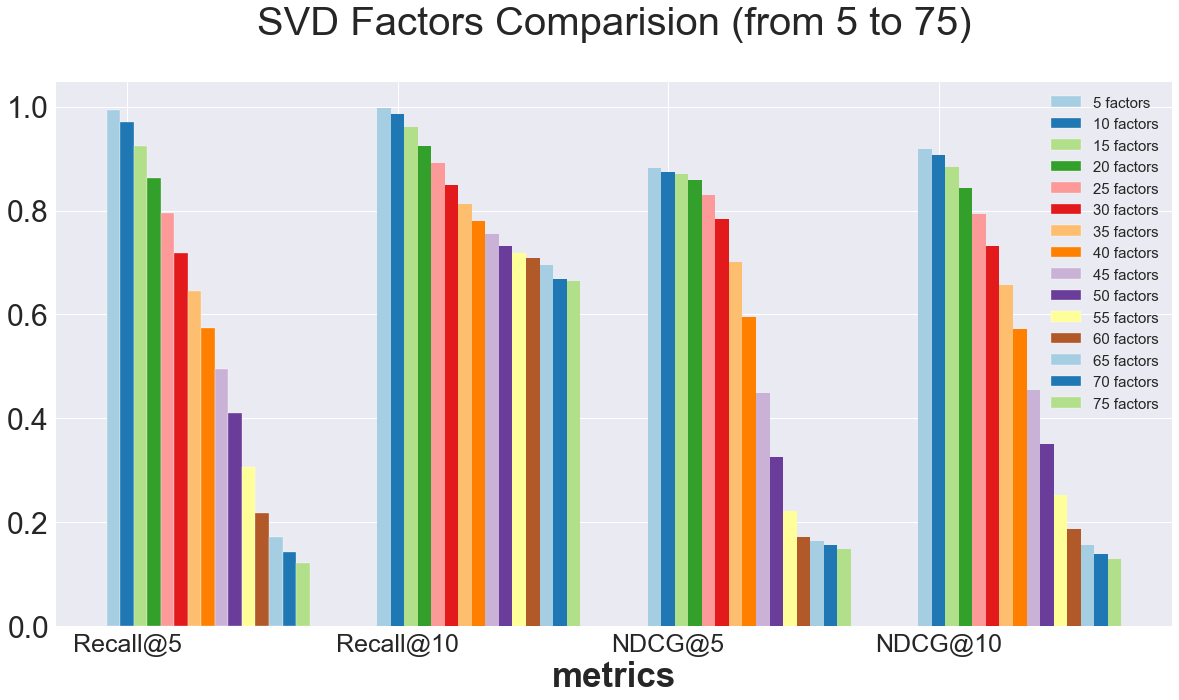

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

nfactors = list(range(5,76,5))
NfactorGridSearch_result
# set width of bar
ax = plt.figure(figsize=(20,10))
barWidth = 0.05

palettes = sns.color_palette("Paired", len(nfactors))
# set height of bar
for idx ,nfac in enumerate(nfactors):
    bar = NfactorGridSearch_result.loc[nfac].tolist()
    if idx == 0:
        r = np.arange(len(bar))
    else:
        r = [x + barWidth for x in r_previous]
    
    r_previous = r
    
    plt.bar(r, bar, color=palettes[idx], width=barWidth, edgecolor='white', label=str(nfac)+' factors')
    
    
plt.xlabel('metrics', fontweight='bold',fontsize =35)

plt.xticks([r + barWidth for r in range(len(bar))], ['Recall@5','Recall@10','NDCG@5','NDCG@10'],fontsize= 25)
plt.yticks(fontsize = 30)
#plt.ylim(0.85,1.5)
plt.title('SVD Factors Comparision (from 5 to 75)\n',fontsize = 40)
# Create legend & Show graphic
plt.legend(fontsize = 15)
plt.show()
ax.savefig('evaluation\\SVDFactorsComparision.png')

K-fold를 이용하여 GridSearch한 결과 잠재요인이 5개 일 때 성능이 가장 좋고 잠재요인이 늘어날수록 성능이 떨어지는 것을 볼 수 있다.
다음으로는 잠재요인이 1개일 때부터 5개 일때까지의 결과를 비교해보도록 하겠다.


In [127]:
from sklearn.model_selection import KFold
import time

cf_model = GoEat.CFRecommender(cf_preds_df, food_df)

nfactors = list(range(1,6))
metrics = ['recall@5','recall@10','ndcg@5','ndcg@10']

total_length =len(nfactors) * 5

accuracies = np.zeros((len(nfactors),len(metrics),5))

start_time = time.time()

count = 0

cv = KFold(5, shuffle=True, random_state=0)
for idx_fold, (idx_train, idx_test) in enumerate(cv.split(interactions_full_df)):
    interactions_train_df = interactions_full_df.iloc[idx_train]
    interactions_test_df = interactions_full_df.iloc[idx_test]
    model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 
    
    for idx_nfactor, nfactor in enumerate(nfactors):
        #cf_preds_df = GoEat.users_items_svd(interactions_train_df, nfactors = nfactor)
        cf_preds_df = GoEat.users_items_svd(interactions_full_df, nfactors = nfactor)
        cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
        with HiddenPrints():
            global_metrics, detailed_results_df = model_evaluator.evaluate_model(cf_model)
        
        count = count + 1
        if count % 10 == 0:
            endtime = time.time() - start_time
            
            percent = round(count/total_length*100,2)
            print('%d percent done(%f seconds)'%(percent,endtime))
            
            approx_time = (endtime/count*total_length - endtime)/60
            
            print('approx. %f minute left'%(round(approx_time)))
        
        for idx_metric, metric in enumerate(metrics):
            accuracies[idx_nfactor][idx_metric][idx_fold] = global_metrics[metric]
        
nfactor_means=[]

for idx_nfactor in range(len(nfactors)):
    metric_means = []
    
    for idx_metric in range(len(metrics)):
        metric_mean = np.mean(accuracies[idx_nfactor][idx_metric])
        metric_means.append(metric_mean)
    
    nfactor_means.append(metric_means)
        


NfactorGridSearch_result2 = pd.DataFrame(nfactor_means,
             index=nfactors,columns=metrics)   

print('complete after %f seconds'%(time.time() - start_time))

NfactorGridSearch_result2


40 percent done(97.467366 seconds)
approx. 2.000000 minute left
80 percent done(189.273871 seconds)
approx. 1.000000 minute left
complete after 232.463380 seconds


,recall@5,recall@10,ndcg@5,ndcg@10
1,0.844734,0.846473,0.859660,0.859859
2,0.998744,1.000000,0.899225,0.933484
3,0.997681,0.999517,0.889078,0.925410
4,0.995652,0.998937,0.882182,0.921507
5,0.993333,0.997295,0.881449,0.918775


In [128]:
NfactorGridSearch_result2.to_csv('evaluation\\NfactorGridSearch_result2.csv')

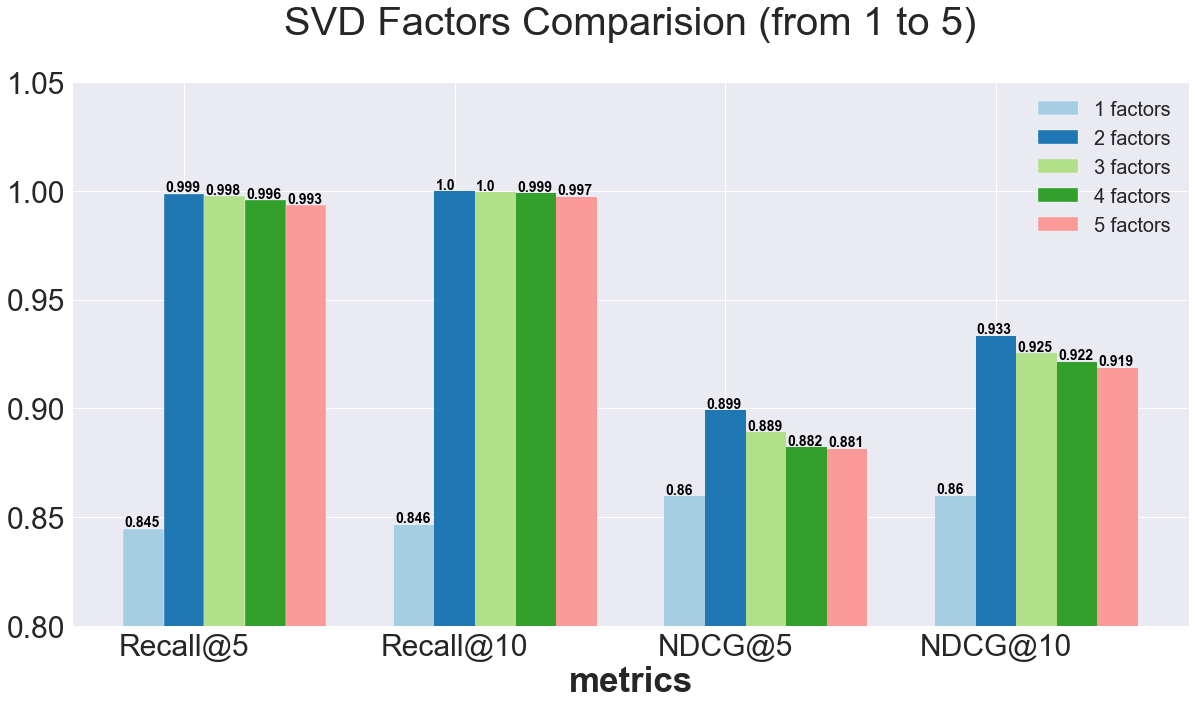

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

nfactors = list(range(1,6))
# set width of bar
ax = plt.figure(figsize=(20,10))
barWidth = 0.15

palettes = sns.color_palette("Paired", len(nfactors))
# set height of bar
for idx ,nfac in enumerate(nfactors):
    bars = NfactorGridSearch_result2.loc[nfac].tolist()
    if idx == 0:
        r = np.arange(len(bar))
    else:
        r = [x + barWidth for x in r_previous]
    
    r_previous = r
    
    plt.bar(r, bars, color=palettes[idx], width=barWidth, edgecolor='white', label=str(nfac)+' factors')
    

    for r_value,value in zip(r,bars):
            plt.text(r_value-0.07, value+0.001, str(round(value,3)),
                     color='black', fontweight='bold',fontsize = 14)
    
    
plt.xlabel('metrics', fontweight='bold',fontsize =35)

plt.xticks([r + barWidth for r in range(len(bar))], ['Recall@5','Recall@10','NDCG@5','NDCG@10'],fontsize= 30)
plt.yticks(fontsize = 30)
plt.ylim(0.8,1.05)
plt.title('SVD Factors Comparision (from 1 to 5)\n',fontsize = 40)
# Create legend & Show graphic
plt.legend(fontsize = 20)
plt.show()
ax.savefig('evaluation\\SVDFactorsComparision2.png')

Grid Search 결과 잠재요인이 2개 일때 가장 추천의 정확도가 높은 것을 알 수 있었다. 이에 따라 잠재요인의 개수를 2개로 설정하였다.

7.Model Comparison using K-Fold
--

In [8]:
#SVD for collborative filtering
cf_preds_df = GoEat.users_items_svd(interactions_full_df, nfactors = 2)

#craeate tfidf and user profiles for content-based filtering

#stopwords
with open('data\\stopwords-ko.txt', 'r',encoding='utf-8') as f:
    lines = f.readlines()
    stopwords_ko = list(map(lambda x: x.rstrip('\n'),lines))
    
#tfidf
tfidf_matrix, tfidf_feature_names = \
GoEat.tfidf_vectorizer(food_detail_df,'foodRecipeNoun',stopwords_ko)

#user profiles
builder= GoEat.user_profiles_builder()
builder.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles = builder.build_users_profiles(interactions_df,food_df,tfidf_matrix)



In [17]:
import time
from sklearn.model_selection import KFold

cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
cb_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix)
hybrid_model_product = GoEat.HybridRecommender(cb_model, cf_model, food_df, method='product')
hybrid_model_harmonic = GoEat.HybridRecommender(cb_model, cf_model, food_df, method='harmonic')

models = [cb_model,cf_model,hybrid_model_product,hybrid_model_harmonic]
model_names = ['Content-based','Collaborative Filtering','Hybrid(product)', 'Hybrid(harmonic)']
metrics = ['recall@5','recall@10','ndcg@5','ndcg@10']

accuracies = np.zeros((len(models),len(metrics),5))
total_length = len(models)*5

count = 0
start_time = time.time()
cv = KFold(5, shuffle=True, random_state=0)
for idx_fold, (idx_train, idx_test) in enumerate(cv.split(interactions_full_df)):
    interactions_train_df = interactions_full_df.iloc[idx_train]
    interactions_test_df = interactions_full_df.iloc[idx_test]
    
    model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 
    
    for idx_model, model in enumerate(models):
        
        with HiddenPrints():
            global_metrics, detailed_results_df = model_evaluator.evaluate_model(model)
        
        count = count + 1
        
        if count % 5 == 0:
            endtime = time.time() - start_time
            
            percent = round(count/total_length*100,2)
            print('%d percent done(%f seconds)'%(percent,endtime))
            
            approx_time = (endtime/count*total_length - endtime)/60
            
            print('approx. %f minute left'%(round(approx_time)))
        
        for idx_metric, metric in enumerate(metrics):
            accuracies[idx_model][idx_metric][idx_fold] = global_metrics[metric]
        
model_means=[]

for idx_model in range(len(models)):
    metric_means = []
    
    for idx_metric in range(len(metrics)):
        metric_mean = np.mean(accuracies[idx_model][idx_metric])
        metric_means.append(metric_mean)
    
    model_means.append(metric_means)            


kfold_result = pd.DataFrame(model_means,
             index=model_names,columns=metrics)   

print('complete after %f minutes'%((time.time() - start_time)/60))

kfold_result
        
        
    
    
    

25 percent done(58.448705 seconds)
approx. 3.000000 minute left
50 percent done(115.374481 seconds)
approx. 2.000000 minute left
75 percent done(170.928928 seconds)
approx. 1.000000 minute left
100 percent done(223.503340 seconds)
approx. 0.000000 minute left
complete after 3.725122 minutes


,recall@5,recall@10,ndcg@5,ndcg@10
Content-based,0.981063,0.984058,0.995294,0.988855
Collaborative Filtering,0.999324,1.000000,0.922576,0.948773
Hybrid(product),0.959807,0.965507,0.991649,0.978857
Hybrid(harmonic),0.980193,0.983575,0.995553,0.988158


In [22]:
kfold_result.to_csv('evaluation\\kfold_model_comparsion_result.csv')

In [21]:
kfold_result = pd.read_csv('evaluation\\kfold_model_comparsion_result.csv',index_col = 0)

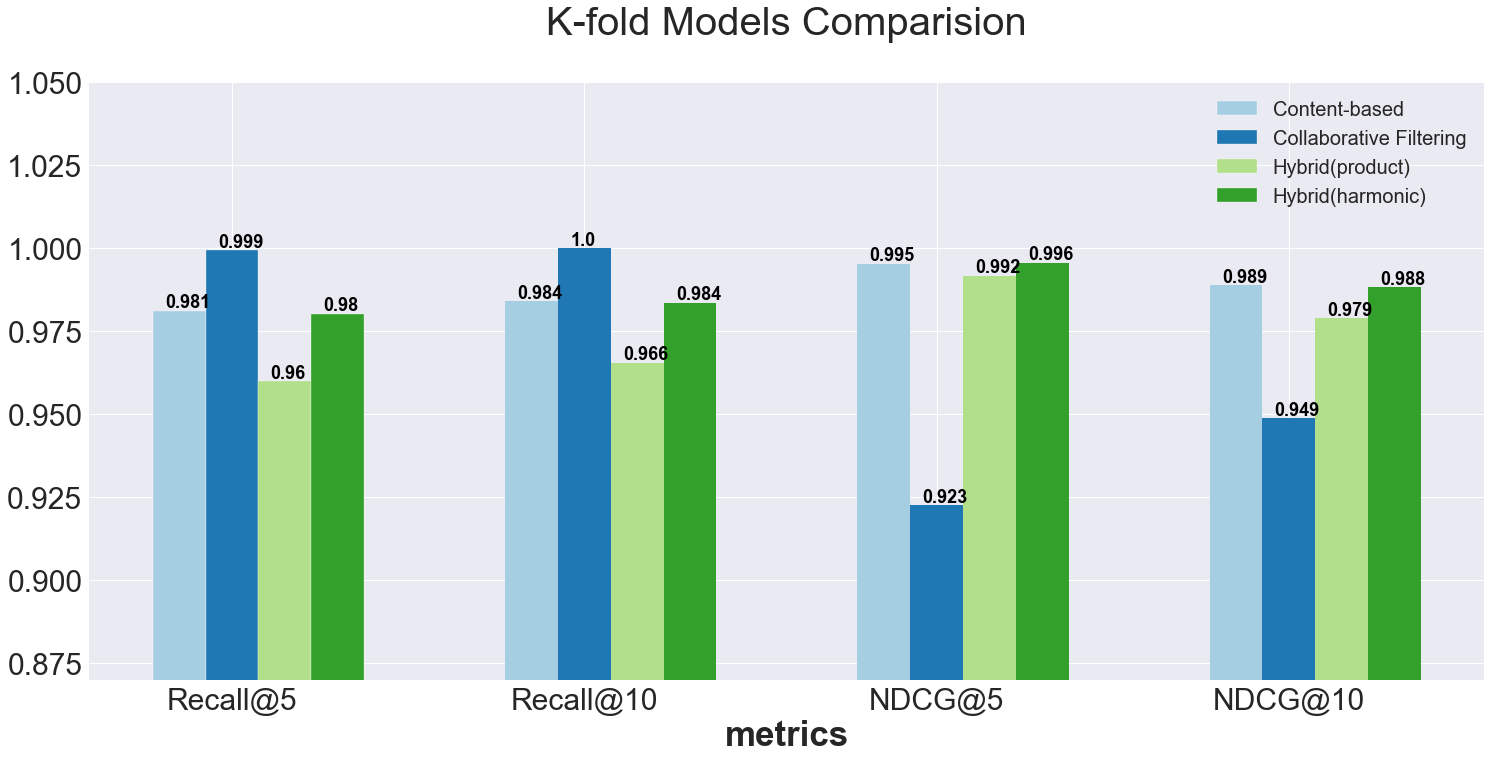

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

model_names = ['Content-based','Collaborative Filtering',
               'Hybrid(product)','Hybrid(harmonic)']

# set width of bar
ax2 = plt.figure(figsize=(25,11))
barWidth = 0.15

palettes = sns.color_palette("Paired", len(model_names))
# set height of bar
for idx ,model_name in enumerate(model_names):
    bars = kfold_result.loc[model_name].tolist()
    if idx == 0:
        r = np.arange(len(bars))
    else:
        r = [x + barWidth for x in r_previous]
    
    r_previous = r
    
    plt.bar(r, bars, color=palettes[idx], width=barWidth, edgecolor='white', label=model_name)
    
    for r_value,value in zip(r,bars):
            plt.text(r_value-0.04, value+0.001, str(round(value,3)), color='black', fontweight='bold',fontsize = 18)
    
plt.xlabel('metrics', fontweight='bold',fontsize =35)
plt.xticks([r + barWidth for r in range(len(bars))], ['Recall@5','Recall@10','NDCG@5','NDCG@10'],fontsize= 30)
plt.yticks(fontsize = 30)
plt.ylim(0.87,1.05)
plt.title('K-fold Models Comparision\n',fontsize = 40)
# Create legend & Show graphic
plt.legend(loc = 'upper right',fontsize= 20)
plt.show()
ax2.savefig('evaluation\\ModelsComparision.png')


Content-based Filtering(CB)과 Collaborative Filtering(CF)를 비교하면, CF가 CB보다 Recall에서 더욱 뛰어난 점수를 받았다.  하지만 NDCG5는 CB가 더 좋은 결과를 보임을 알수 있다.

CB와 CF를 조합하여 Hybrid Filtering을 실행하였다. 첫번 째 모델은 단순히 CF와 CB값을 곱하였으며, 두번 째 모델은 CB와 CF의 조화평균을 이용하였다. 그 결과 두 값의 단순곱을 한 모델은 다른 모델들보다 성능이 저하되었고, 조화평균을 한 모델은 다른 모델들과 거의 비슷한 결과를 보여주었다.

Recall의 경우 Hybrid 모델이 CF나 CB보다 성능이 0.2% 정도 낮았다. 한편 NDCG@5에서는 근소하지만 Hyrid model이 가장 좋은 성능을 보였다. 본 추천 시스템에서 가장 중요한 것은 상위 5개의 순위를 얼마나 잘 맞추냐 이기 때문에 결국은 NDCG@5에서 가장 나은 성느을 보인  조화평균 Hybrid 모델이 최종 모델로 선정되었다.




8.상황에 따른 음식 추천 기능
==

In [166]:
import pandas as pd
import numpy as np
import sklearn
import scipy

In [167]:
df_user_eat = pd.read_csv(".\\data\\info\\df_user_eat.csv")
df_user_eat.userId = df_user_eat.userId + 1

In [168]:
eatAlone = [str(word).replace("nan","").replace(","," ") for word in list(df_user_eat.eatAlone)]
eatDate = [str(word).replace("nan","").replace(","," ") for word in list(df_user_eat.eatDate)]
eatTogether = [str(word).replace("nan","").replace(","," ") for word in list(df_user_eat.eatTogether)]

In [169]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
cvAlone = CountVectorizer()
cvAlone_result = cvAlone.fit_transform(eatAlone)
vocabAlone = cvAlone.get_feature_names()
df_eatAlone =  pd.DataFrame(cvAlone_result.toarray(),columns = vocabAlone)
df_eatAlone_count = pd.DataFrame(df_eatAlone.sum().sort_values(ascending =False))
df_eatAlone_count = df_eatAlone_count.reset_index()
df_eatAlone_count.columns = ["foodName","eatAlone"]

In [171]:
cvDate = CountVectorizer()
cvDate_result = cvDate.fit_transform(eatDate)
vocabDate = cvDate.get_feature_names()
df_eatDate =  pd.DataFrame(cvDate_result.toarray(),columns = vocabDate)
df_eatDate_count = pd.DataFrame(df_eatDate.sum().sort_values(ascending =False))
df_eatDate_count = df_eatDate_count.reset_index()
df_eatDate_count.columns = ["foodName","eatDate"]

In [172]:
cvTogether = CountVectorizer()
cvTogether_result = cvTogether.fit_transform(eatTogether)
vocabTogether = cvTogether.get_feature_names()
df_eatTogether =  pd.DataFrame(cvTogether_result.toarray(),columns = vocabTogether)
df_eatTogether_count = pd.DataFrame(df_eatTogether.sum().sort_values(ascending =False))
df_eatTogether_count = df_eatTogether_count.reset_index()
df_eatTogether_count.columns = ["foodName","eatTogether"]

In [173]:
df_food_situation = food_df.join(df_eatAlone_count.set_index('foodName'),on = 'foodName',how='left')
df_food_situation = df_food_situation.join(df_eatDate_count.set_index('foodName'),on = 'foodName',how='left')
df_food_situation = df_food_situation.join(df_eatTogether_count.set_index('foodName'),on = 'foodName',how='left')
df_food_situation.fillna(0,inplace = True)

In [174]:
df_food_situation_ratio = df_food_situation.copy()
df_food_situation_ratio.eatAlone = df_food_situation_ratio.eatAlone/sum(df_food_situation_ratio.eatAlone)
df_food_situation_ratio.eatDate = df_food_situation_ratio.eatDate/sum(df_food_situation_ratio.eatDate)
df_food_situation_ratio.eatTogether = df_food_situation_ratio.eatTogether/sum(df_food_situation_ratio.eatTogether)

상황에 따른 음식 가중치 형성

In [175]:
df_food_situation_ratio2 = df_food_situation_ratio.copy()
sum_of_ratio = df_food_situation_ratio2[['eatAlone','eatDate','eatTogether']].sum(axis=1)
df_food_situation_ratio2.eatAlone = df_food_situation_ratio2.eatAlone/sum_of_ratio
df_food_situation_ratio2.eatDate = df_food_situation_ratio2.eatDate/sum_of_ratio
df_food_situation_ratio2.eatTogether = df_food_situation_ratio2.eatTogether/sum_of_ratio
df_food_situation_ratio2.head()

,foodIndex,foodName,eatAlone,eatDate,eatTogether
1,1,볶음밥,0.861910,0.091519,0.046572
2,2,김치찌개,0.652629,0.246870,0.100501
3,3,된장찌개,0.680634,0.214553,0.104814
4,4,닭갈비,0.000000,0.224197,0.775803
5,5,닭도리탕,0.494888,0.166401,0.338710


In [176]:
df_food_situation_ratio2 =df_food_situation_ratio2.fillna(1e-6).replace(to_replace = 0,value = 1e-6)

In [177]:
from sklearn.cluster import KMeans

In [193]:
food_features = df_food_situation_ratio2[["eatAlone","eatDate","eatTogether"]]
kmeans_situation = KMeans(n_clusters=3).fit(food_features)

In [194]:
predict = pd.DataFrame(kmeans_situation.predict(food_features))
predict.index = predict.index + 1
predict.columns=['predicted_label']
r = pd.concat([df_food_situation_ratio2,predict],axis=1)
centers = pd.DataFrame(kmeans_situation.cluster_centers_,columns=['eatAlone','eatTogether','eatDate'])

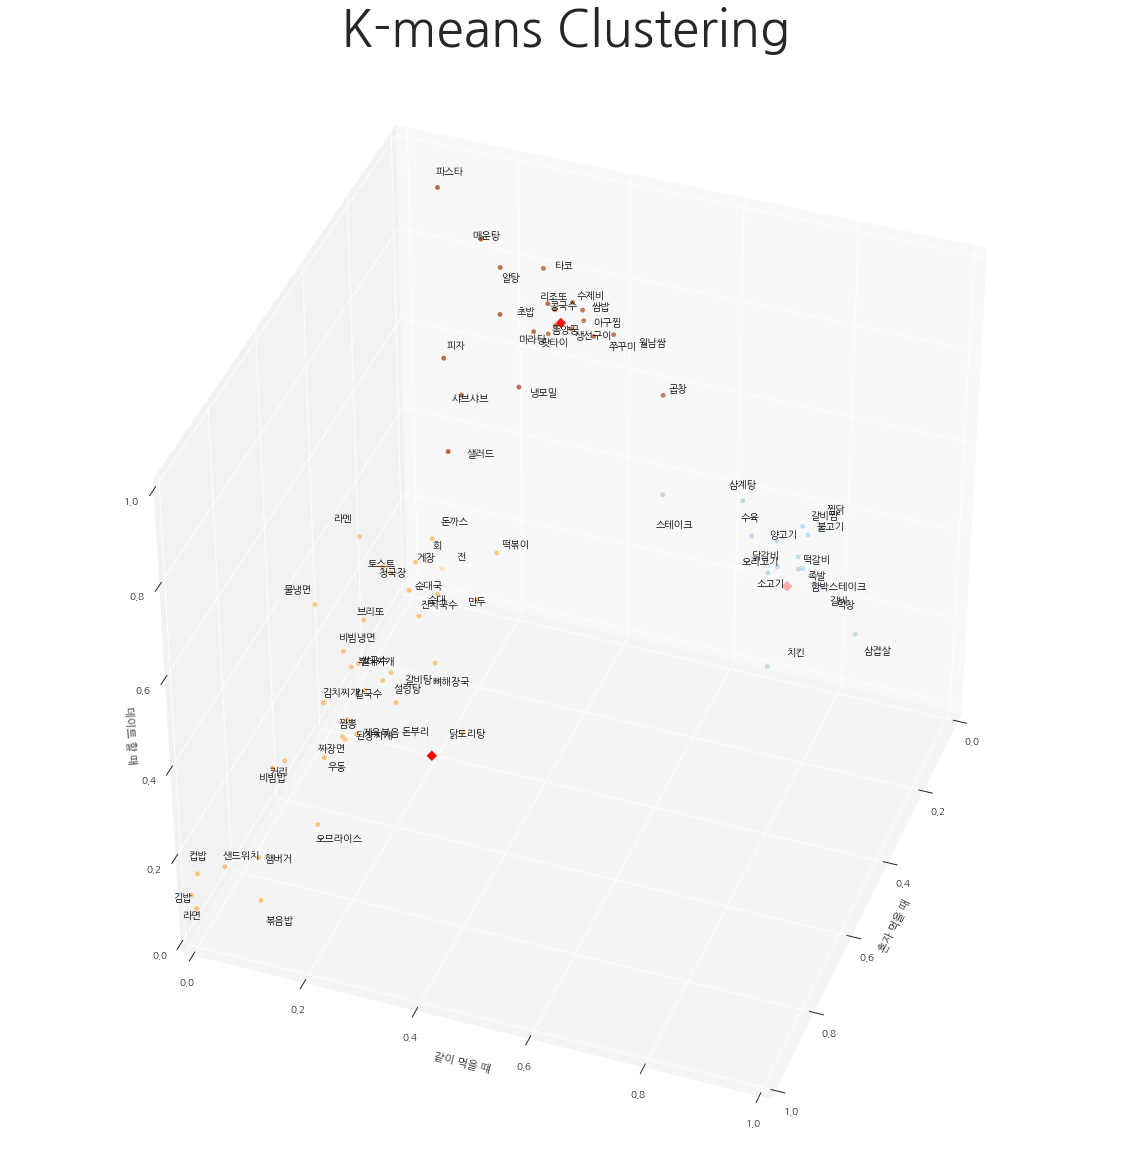

In [207]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'

np.random.seed(10)
jitter1 = np.random.randn(len(r))/25
np.random.seed(20)
jitter2 = np.random.randn(len(r))/25
np.random.seed(30)
jitter3 = np.random.randn(len(r))/25
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111, projection='3d')
cm = plt.get_cmap("Paired")
ax.scatter(r['eatAlone']+jitter1,r['eatTogether']+jitter2,r['eatDate']+jitter3, c=r['predicted_label'],cmap =cm)

for i in r.index: #plot each point + it's index as text above
    
    ax.text(r.loc[i,'eatAlone']+jitter1[i-1]*1.5,
            r.loc[i,'eatTogether']+jitter2[i-1]*1.5,
            r.loc[i,'eatDate']+jitter3[i-1]*1.5,  '%s' % (r.loc[i,'foodName']), size=10, zorder=1, color='k') 
ax.set_title('K-means Clustering\n\n',fontsize = 50)
ax.set_xlabel('혼자 먹을 때')
ax.set_ylabel('같이 먹을 떄')
ax.set_zlabel('데이트 할 때')
ax.set_facecolor((1.0, 1.0, 1.0))
center_x = centers['eatAlone']

center_y = centers['eatTogether']

center_z = centers['eatDate']

ax.scatter(center_x,center_y,center_z, s = 50, c = 'red', marker='D')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

x = r['eatAlone']
y = r['eatTogether']
z = r['eatDate']
n = r['foodName']
    
angle = 20
ax.view_init(40, angle)
plt.show()

ax.figure.savefig('evaluation\\kmeanfood.png')


In [196]:
df_Alone =df_user_eat[["userId","eatAlone"]]
df_Date =df_user_eat[["userId","eatDate"]]
df_Together =df_user_eat[["userId","eatTogether"]]

In [187]:
from itertools import compress

In [188]:
eatHow = [df_eatAlone,df_eatDate,df_eatTogether]
VocabList = [vocabAlone,vocabDate,vocabTogether]
eatHowstr = ['eatAlone','eatDate','eatTogether']


for idx, eat in enumerate(eatHow):
    eatlist = []
    
    for id in range(len(eat)):
        interacted_food = list(compress(VocabList[idx],eatHow[idx].iloc[id] == 1))
    
        for food in interacted_food:
            foodIndex = int(food_df.foodIndex[food_df.foodName == food].values)
            eatlist.append([id+1, foodIndex, 1])
        
    vars()['df_interactions_'+eatHowstr[idx]] = pd.DataFrame(eatlist,columns= ['userIndex','foodIndex','eventStrength'])
            
    

In [189]:
df_food_cluster =r.rename(columns = {'predicted_label':'group','foodId':'foodIndex'})

음식 클러스터

In [190]:
df_food_cluster.head()

,foodIndex,foodName,eatAlone,eatDate,eatTogether,group
1,1,볶음밥,0.861910,0.091519,0.046572,3
2,2,김치찌개,0.652629,0.246870,0.100501,3
3,3,된장찌개,0.680634,0.214553,0.104814,3
4,4,닭갈비,0.000001,0.224197,0.775803,1
5,5,닭도리탕,0.494888,0.166401,0.338710,0


In [191]:
#SVD for collborative filtering
cf_preds_df = GoEat.users_items_svd(interactions_full_df, nfactors = 2)

#craeate tfidf and user profiles for content-based filtering

#tfidf
tfidf_matrix, tfidf_feature_names = \
GoEat.tfidf_vectorizer(food_detail_df,'foodRecipeNoun',stopwords_ko)

#user profiles
builder= GoEat.user_profiles_builder()
builder.get_interacted_indexed_df(interactions_full_df,food_df)
user_profiles = builder.build_users_profiles(interactions_df,food_df,tfidf_matrix)

cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
cb_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix)
hybrid_model = GoEat.HybridRecommender(cb_model, cf_model, food_df, method='harmonic')

In [192]:
cf_preds_user_df = GoEat.users_items_svd(interactions_full_df)
cf_user_model = GoEat.CFRecommender(cf_preds_user_df, food_df)

cf_preds_Alone_df = GoEat.users_items_svd(df_interactions_eatAlone, nfactors = 20)
cf_Alone_model = GoEat.CFRecommender(cf_preds_Alone_df, food_df)

cf_preds_Date_df = GoEat.users_items_svd(df_interactions_eatDate, nfactors = 20)
cf_Date_model = GoEat.CFRecommender(cf_preds_Date_df, food_df)

cf_preds_Together_df = GoEat.users_items_svd(df_interactions_eatTogether, nfactors = 20)
cf_Together_model = GoEat.CFRecommender(cf_preds_Together_df, food_df)

In [69]:
df_interactions_eatAlone.to_csv('data\\info\\interactions_eatAlone.csv',encoding = 'cp949',index=False)
df_interactions_eatDate.to_csv('data\\info\\interactions_eatDate.csv',encoding = 'cp949',index=False)
df_interactions_eatTogether.to_csv('data\\info\\interactions_eatTogether.csv',encoding = 'cp949',index=False)

In [125]:
#가중치 곱
userIndex = 33
idx = 2


if idx == 0:
    sit = '혼자'
elif idx == 1:
    sit = '함께'
elif idx == 2:
    sit = '데이트'
rec_user = hybrid_model.recommend_items(userIndex,topn=100,verbose = True)
rec_user = rec_user.rename(columns = {'recStrengthHybrid':'recStrength_user'})
sit_name = ['eatAlone','eatTogether','eatDate']
rec_situation = df_food_cluster[['foodIndex',sit_name[idx]]]
rec_situation.columns = ['foodIndex','recStrength_sit']

rec_by_sit = pd.merge(rec_user,rec_situation,on ='foodIndex',how= 'outer').fillna(1e-5)
rec_by_sit['recStrength'] = rec_by_sit.recStrength_user*rec_by_sit.recStrength_sit
rec_by_sit = rec_by_sit.sort_values(by='recStrength',ascending =False)
print('[ 추천강도 * 가중치 ]\n')
print('유저번호 : %d\n상황 : %s\n'%(userIndex,sit))
rec_by_sit.head(3)

[ 추천강도 * 가중치 ]

유저번호 : 33
상황 : 데이트



,recStrength_user,foodIndex,foodName,recStrength_sit,recStrength
12,0.292168,27,파스타,0.891862,0.260574
2,0.323341,18,초밥,0.743399,0.240372
10,0.319971,26,리조또,0.710681,0.227397


In [133]:
#클러스터 내에서만 콜라보

userIndex = 33 #유저 번호
idx = 0 #상황

if idx == 0:
    sit = '데이트'
elif idx == 1:
    sit = '혼자'
elif idx == 2:
    sit = '함께'

interactions_within_group = interactions_full_df[
    interactions_full_df.foodIndex.isin(
        df_food_cluster[df_food_cluster['group'] == idx].foodIndex)]
    
cf_preds_user_df = GoEat.users_items_svd(interactions_within_group)
cf_user_model = GoEat.CFRecommender(cf_preds_user_df, food_df)

cb_user_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix)
hybrid_user_model = GoEat.HybridRecommender(cb_user_model, cf_user_model, food_df, method='harmonic')
print('[ cluster 내에서 collaborative filtering ]\n')
print('유저번호 : %d\n상황 : %s\n'%(userIndex,sit))
hybrid_user_model.recommend_items(userIndex,topn=3,verbose = True)

[ cluster 내에서 collaborative filtering ]

유저번호 : 33
상황 : 데이트



,recStrengthHybrid,foodIndex,foodName
0,0.324210,23,냉모밀
1,0.324193,26,리조또
2,0.324075,32,샤브샤브


In [134]:
#Group내 결과만 표시


userIndex = 33 #유저 번호
idx = 0 #상황

if idx == 0:
    sit = '데이트'
elif idx == 1:
    sit = '혼자'
elif idx == 2:
    sit = '함께'
    
rec_user = hybrid_model.recommend_items(userIndex,topn=100,verbose = True)
print('cluster 내의 결과만 표시\n')
print('유저번호 : %d\n상황 : %s\n'%(userIndex,sit))
rec_user[rec_user.foodIndex.isin(df_food_cluster[df_food_cluster['group'] == idx].foodIndex)].head(3)

cluster 내의 결과만 표시

유저번호 : 33
상황 : 데이트



,recStrengthHybrid,foodIndex,foodName
2,0.323341,18,초밥
6,0.322179,32,샤브샤브
8,0.321009,23,냉모밀


In [58]:
#콜라보 * 콜라보


userIndex = 33 #유저 번호
idx = 2 #상황

if idx == 0:
    sit = '혼자'
elif idx == 1:
    sit = '함께'
elif idx == 2:
    sit = '데이트'
    
situation_model = {'EatAlone':cf_Alone_model,'EatDate':cf_Date_model,'EatTogether':cf_Together_model}
sit_name = ['EatAlone','EatTogether','EatDate']

rec_user = hybrid_model.recommend_items(userIndex,topn=100,verbose = True)
rec_user = rec_user.rename(columns = {'recStrengthHybrid':'recStrength_user'})

try:
    rec_situation = situation_model[sit_name[idx]].recommend_items(userIndex,topn=100)
except:
    rec_situation = rec_default
    
rec_situation = rec_situation.rename(columns = {'recStrength':'recStrength_sit'})

rec_by_sit = pd.merge(rec_user,rec_situation,on ='foodIndex',how= 'outer').fillna(1e-5)
rec_by_sit['recStrength'] = rec_by_sit.recStrength_user*rec_by_sit.recStrength_sit
rec_by_sit = rec_by_sit.sort_values(by='recStrength',ascending =False)
print('상황에 따른 콜라보 * 추천 강도\n')
print('유저번호 : %d\n상황 : %s\n'%(userIndex,sit))
rec_by_sit.head(3)

상황에 따른 콜라보 * 추천 강도

유저번호 : 33
상황 : 데이트



,recStrength_user,foodIndex,foodName,recStrength_sit,recStrength
12,0.292168,27,파스타,0.999732,0.292090
10,0.319971,26,리조또,0.014619,0.004678
36,0.251682,28,함박스테이크,0.001366,0.000344
